# 1. Import dataset and libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('rideshare_kaggle.csv')

#print the dataset
data[0:5]

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


# 2. Exploratory data analysis

In [5]:
# Overview

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

In [6]:
#Check if there are any null values
missing_values = data.isnull().sum()
print(missing_values)

id                                 0
timestamp                          0
hour                               0
day                                0
month                              0
datetime                           0
timezone                           0
source                             0
destination                        0
cab_type                           0
product_id                         0
name                               0
price                          55095
distance                           0
surge_multiplier                   0
latitude                           0
longitude                          0
temperature                        0
apparentTemperature                0
short_summary                      0
long_summary                       0
precipIntensity                    0
precipProbability                  0
humidity                           0
windSpeed                          0
windGust                           0
windGustTime                       0
v

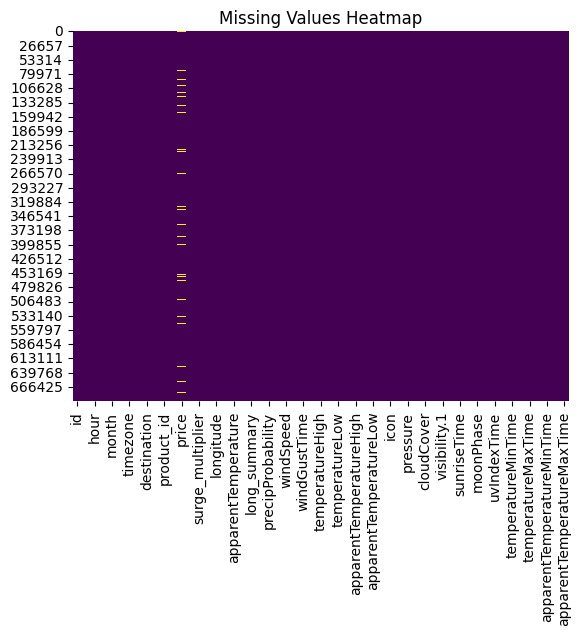

In [7]:
# Visualizing missing values
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [8]:
# Check duplicates
duplicates = data.duplicated().sum()

print(duplicates)

0


- There are 55095 null values in price, we can not use this values to train our model because price is our target value.
- There is no duplicate data


## 2.1 Price is our Target variable

Let's check more information about the price variable.

In [9]:
#Load prices into variable
prices = data['price']
#Print description
print(prices.describe())

count    637976.000000
mean         16.545125
std           9.324359
min           2.500000
25%           9.000000
50%          13.500000
75%          22.500000
max          97.500000
Name: price, dtype: float64


Text(0, 0.5, 'Occurences')

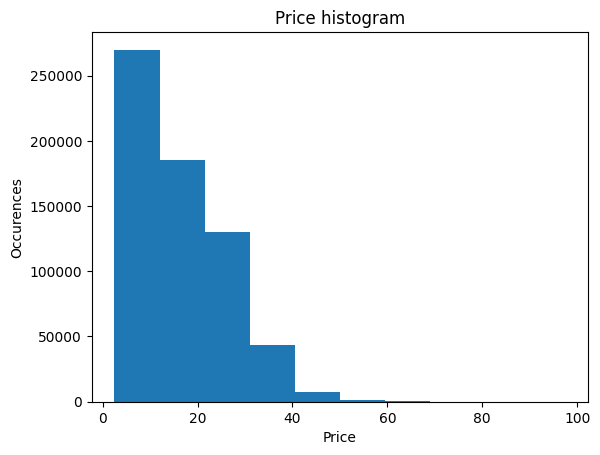

In [10]:
#make a histogram

plt.hist(prices)
plt.title('Price histogram')
plt.xlabel('Price')
plt.ylabel('Occurences')

### 2.1.1 What kind of missind data we have in price?

There are 3 different types of missing data 

| Type | What it means | Real-world example |
|------|----------------|--------------------|
| **MCAR** | Missing Completely At Random | If  `price` values are missing randomly due to a system glitch |
| **MAR**  | Missing At Random | If `price` is missing more often when `cab_type` is "Uber" |
| **MNAR** | Missing Not At Random | If high prices are intentionally not recorded |


In [11]:
# Separate the dataset to understand the missing data
with_price = data[data['price'].notnull()]
without_price = data[data['price'].isnull()]

# check if 'cab_type' distribution is different
print("With price:")
print(with_price['cab_type'].value_counts(normalize=True))

print("Without price:")
print(without_price['cab_type'].value_counts(normalize=True))


With price:
cab_type
Uber    0.518151
Lyft    0.481849
Name: proportion, dtype: float64
Without price:
cab_type
Uber    1.0
Name: proportion, dtype: float64


It is a **MAR** case, because the missing values only happen with UBER rides!

## 2.2 Separate Uber and Lyft in two variables

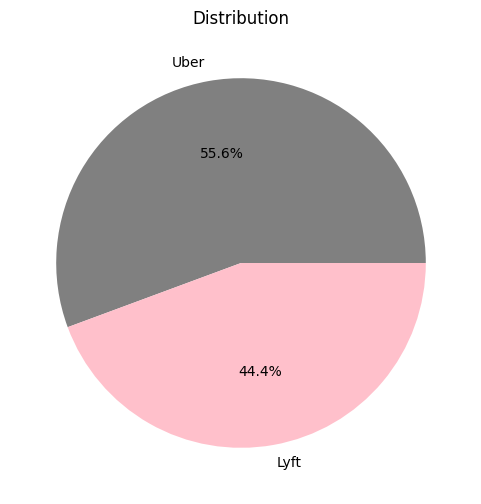

In [12]:
#Separate Uber and Lyft in two variables

uber_data = data[data['cab_type'] == 'Uber']
lyft_data = data[data['cab_type'] == 'Lyft']

# Overview

# print(uber_data.info())


#print(lyft_data.info())

# The data set is well divided, we have half of the values by uber and half by lyft

# Create a dictionary with counts
ride_counts = {
    'Uber': len(uber_data),
    'Lyft': len(lyft_data)
}

cor = ['grey', 'pink']

# Generate pie chart
plt.figure(figsize=(6, 6))
plt.pie(ride_counts.values(), labels=ride_counts.keys(), colors=cor, autopct='%1.1f%%')
plt.title('Distribution')


plt.show()

## 2.3 Surge Multiplier

The surge multiplier is a component of the pricing algorithm that dynamically adjusts fare prices based on real-time demand and supply conditions

https://www.uber.com/us/en/drive/driver-app/how-surge-works/

**The problem is that in this dataset, all Uber data uses the surge multiplier as 1.0 (i.e. the default value). We cannot know if this is an error or not and how it might impact our model.**

In [13]:
#Understanding the use of Surge Multiplier

print("UBER")
print(uber_data["surge_multiplier"].mean())
print(uber_data["surge_multiplier"].median())

print("LYFT")
print(lyft_data["surge_multiplier"].mean())
print(lyft_data["surge_multiplier"].median())

UBER
1.0
1.0
LYFT
1.0312703312861085
1.0


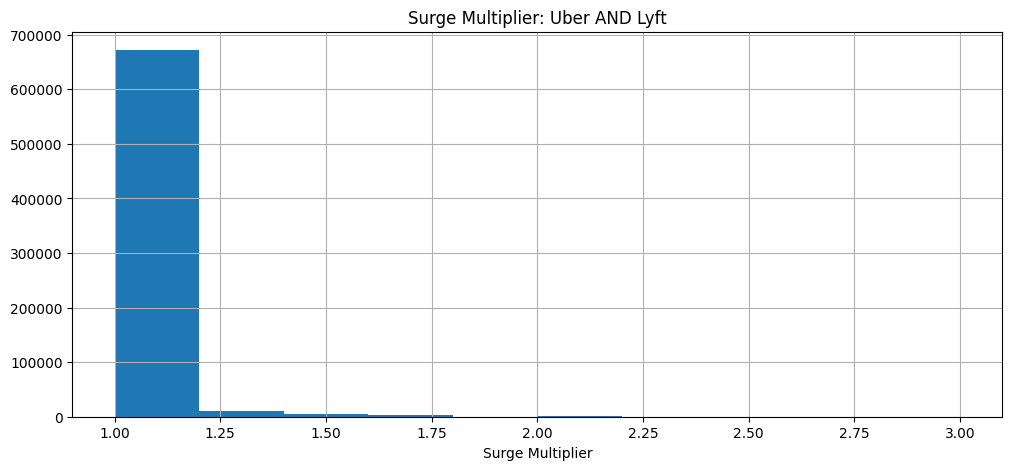

In [14]:
#  'price' vs 'surge_multiplier'
plt.figure(figsize=(12, 5))
plt.hist(data["surge_multiplier"]) 
# alpha = 0.2 (changes opacity)
plt.xlabel("Surge Multiplier")
plt.title('Surge Multiplier: Uber AND Lyft')
plt.grid(True)
plt.show()

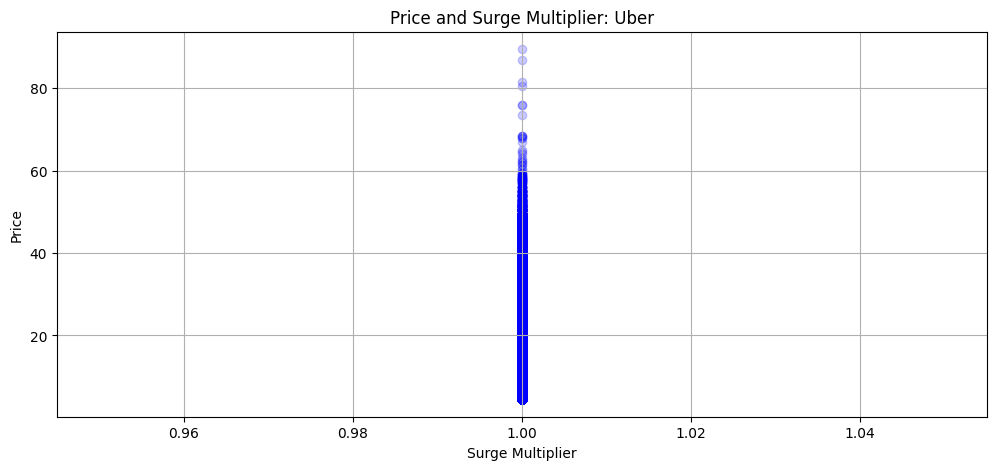

In [15]:
# Only Uber
plt.figure(figsize=(12, 5))
plt.scatter(uber_data["surge_multiplier"], uber_data["price"], alpha=0.2, color="blue") 
# alpha = 0.2 (changes opacity)
plt.xlabel("Surge Multiplier")
plt.title('Price and Surge Multiplier: Uber')
plt.ylabel("Price")
plt.grid(True)
plt.show()

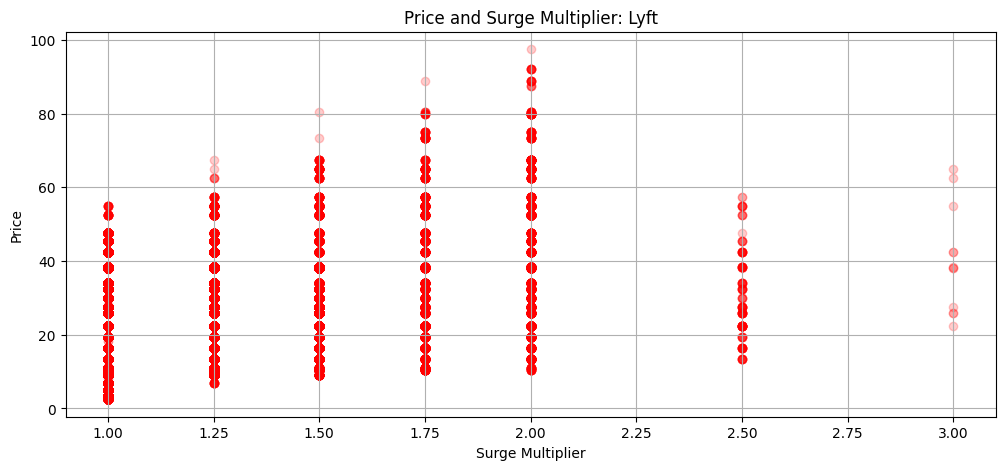

In [16]:
# Only Lyft
plt.figure(figsize=(12, 5))
plt.scatter(lyft_data["surge_multiplier"], lyft_data["price"], alpha=0.2, color="red") 
# alpha = 0.2 (changes opacity)
plt.xlabel("Surge Multiplier")
plt.title('Price and Surge Multiplier: Lyft')
plt.ylabel("Price")
plt.grid(True)
plt.show()

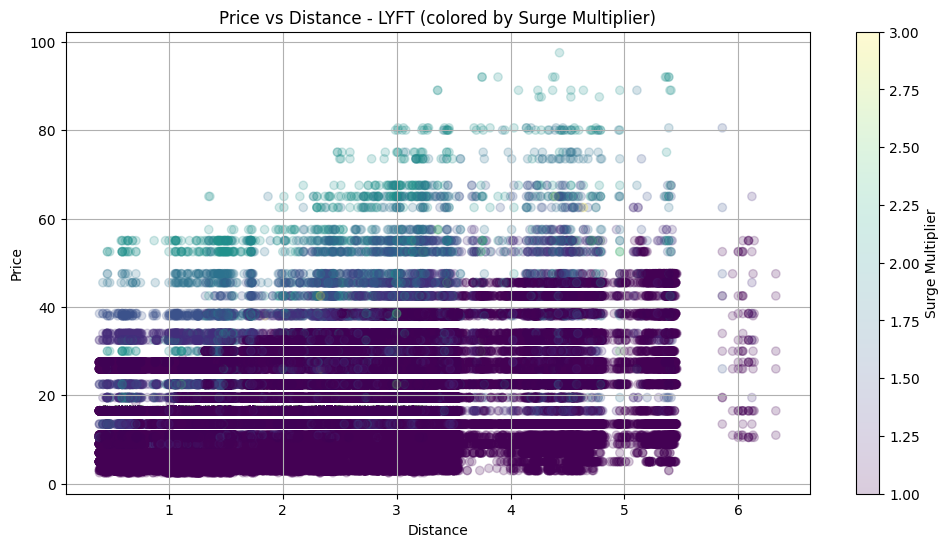

In [17]:
plt.figure(figsize=(12, 6))

# Scatter plot with colors to surge multiplier
scatter = plt.scatter(
    lyft_data["distance"],
    lyft_data["price"],
    c=lyft_data["surge_multiplier"],
    alpha=0.2
)

# Color bar to surge multiplier
plt.colorbar(scatter, label='Surge Multiplier')

plt.xlabel("Distance")
plt.ylabel("Price")
plt.title("Price vs Distance - LYFT (colored by Surge Multiplier)")
plt.grid(True)

plt.show()

Only Lyft uses DIFFERENT surge multipliers in this dataset, which looks like an error. Uber also uses this variable, but in this dataset is always one. When doing feature engineering we will have to discuss if we are going to use this variable or not.

## 2.4 Compare the target variable with other variables

### Scaterplot


C:\Users\ligia\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


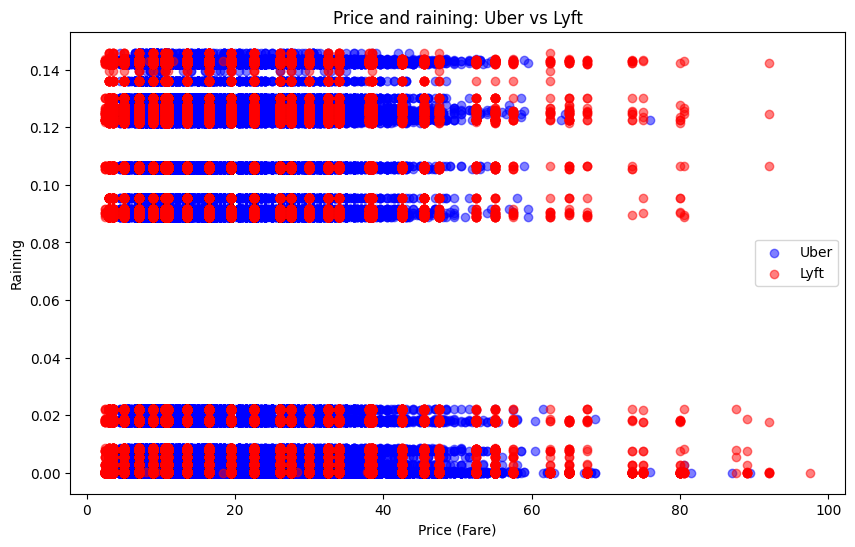

In [18]:
# Compare price and precipIntensityMax
plt.figure(figsize=(10, 6))
plt.scatter(uber_data['price'], uber_data['precipIntensityMax'], color='blue', alpha=0.5, label='Uber')
plt.scatter(lyft_data['price'], lyft_data['precipIntensityMax'], color='red', alpha=0.5, label='Lyft')

plt.xlabel('Price (Fare)')
plt.ylabel('Raining')
plt.title('Price and raining: Uber vs Lyft')
plt.legend()
plt.show()

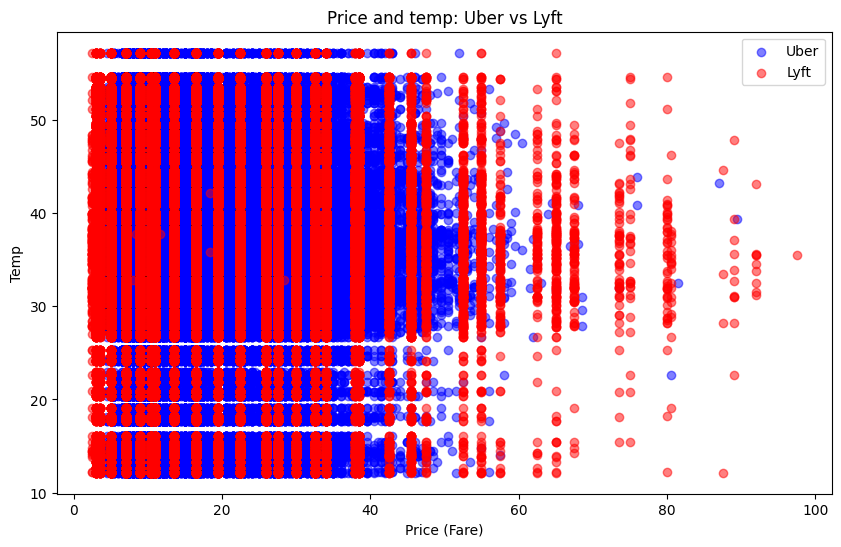

In [19]:
# Compare price and Temperature
plt.figure(figsize=(10, 6))
plt.scatter(uber_data['price'], uber_data['apparentTemperature'], color='blue', alpha=0.5, label='Uber')
plt.scatter(lyft_data['price'], lyft_data['apparentTemperature'], color='red', alpha=0.5, label='Lyft')

plt.xlabel('Price (Fare)')
plt.ylabel('Temp')
plt.title('Price and temp: Uber vs Lyft')
plt.legend()
plt.show()

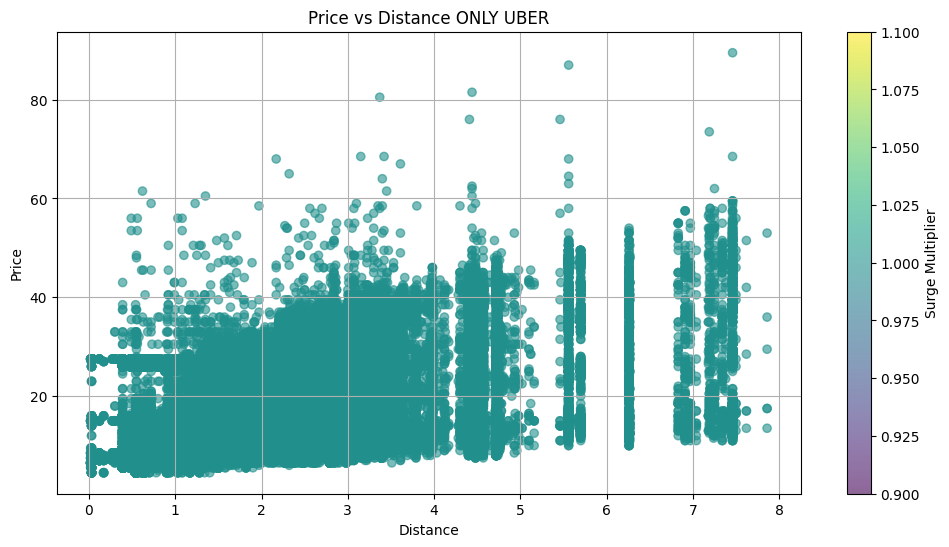

In [20]:
plt.figure(figsize=(12, 6))

# Scatter plot with colors to surge multiplier
scatter = plt.scatter(
    uber_data["distance"],
    uber_data["price"],
    c=uber_data["surge_multiplier"],
    alpha=0.6
)

# Color bar to surge multiplier
plt.colorbar(scatter, label='Surge Multiplier')

plt.xlabel("Distance")
plt.ylabel("Price")
plt.title("Price vs Distance ONLY UBER")
plt.grid(True)

plt.show()



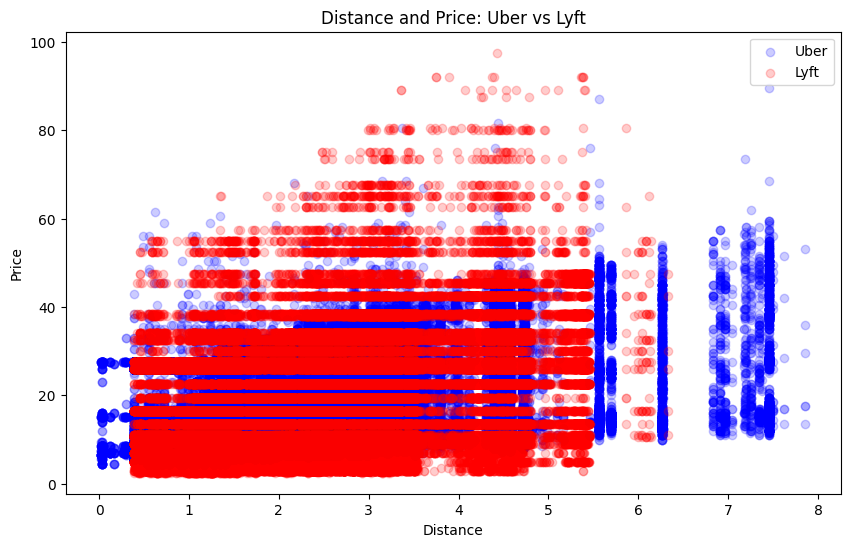

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(uber_data['distance'], uber_data['price'], color='blue', alpha=0.2 , label='Uber')
plt.scatter(lyft_data['distance'], lyft_data['price'], color='red', alpha=0.2, label='Lyft')

# I used ALPHA 0.2 to let the dots with 20% of opacity so we can see it better

plt.xlabel('Distance')
plt.ylabel('Price')
plt.title('Distance and Price: Uber vs Lyft')
plt.legend()
plt.show()

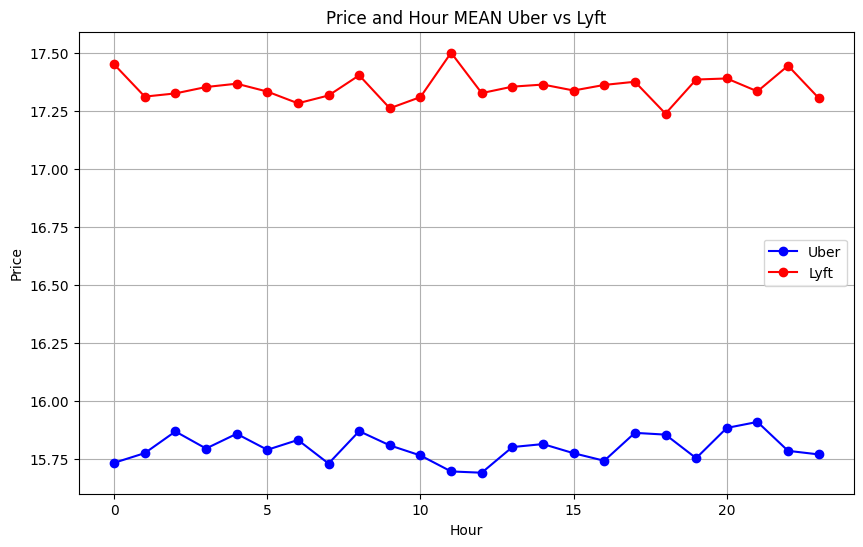

In [22]:
# Price mean to every hour
uber_avg_price = uber_data.groupby('hour')['price'].mean()
lyft_avg_price = lyft_data.groupby('hour')['price'].mean()

plt.figure(figsize=(10, 6))
plt.plot(uber_avg_price.index, uber_avg_price.values, color='blue', marker='o', label='Uber')
plt.plot(lyft_avg_price.index, lyft_avg_price.values, color='red', marker='o', label='Lyft')

plt.xlabel('Hour')
plt.ylabel('Price')
plt.title('Price and Hour MEAN Uber vs Lyft')
plt.legend()
plt.grid(True)
plt.show()


## 2.5 Correlation Matrix

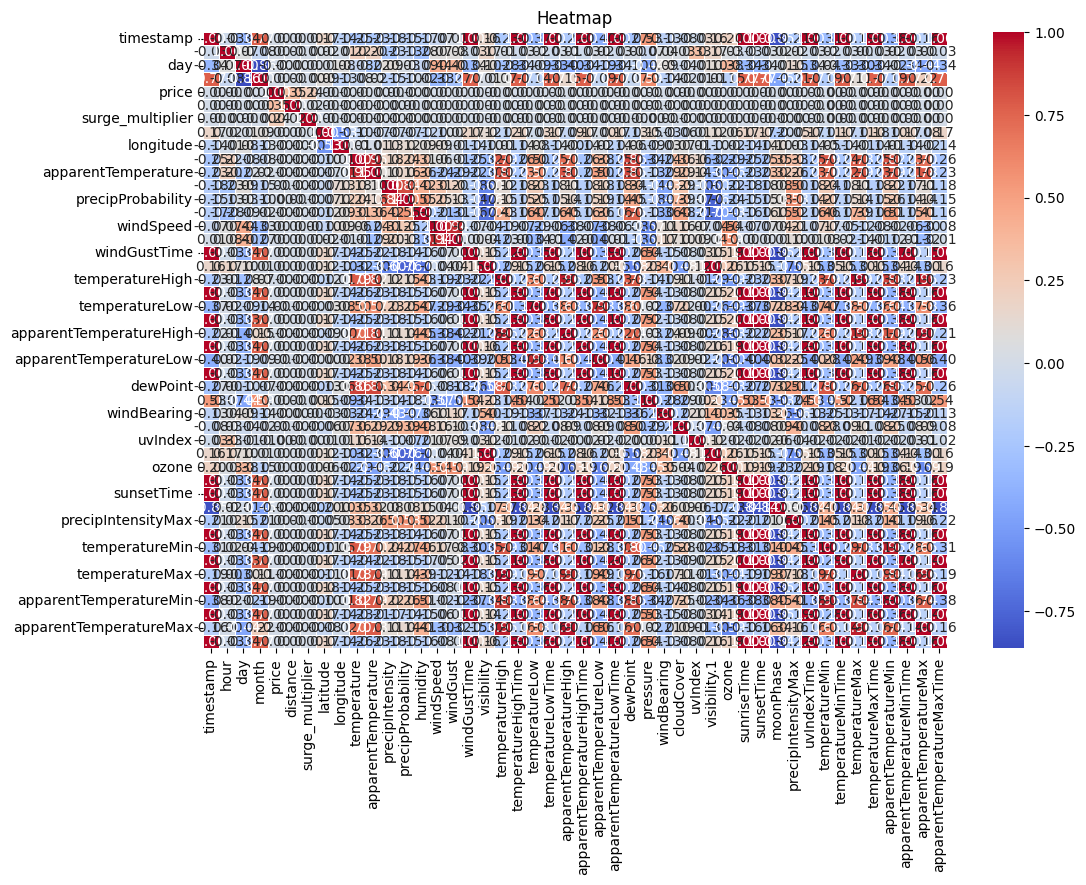

In [23]:
# Select ONLY NUMERIC DATA
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Correlation matrix
correlation_matrix = numeric_data.corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Heatmap')
plt.show()


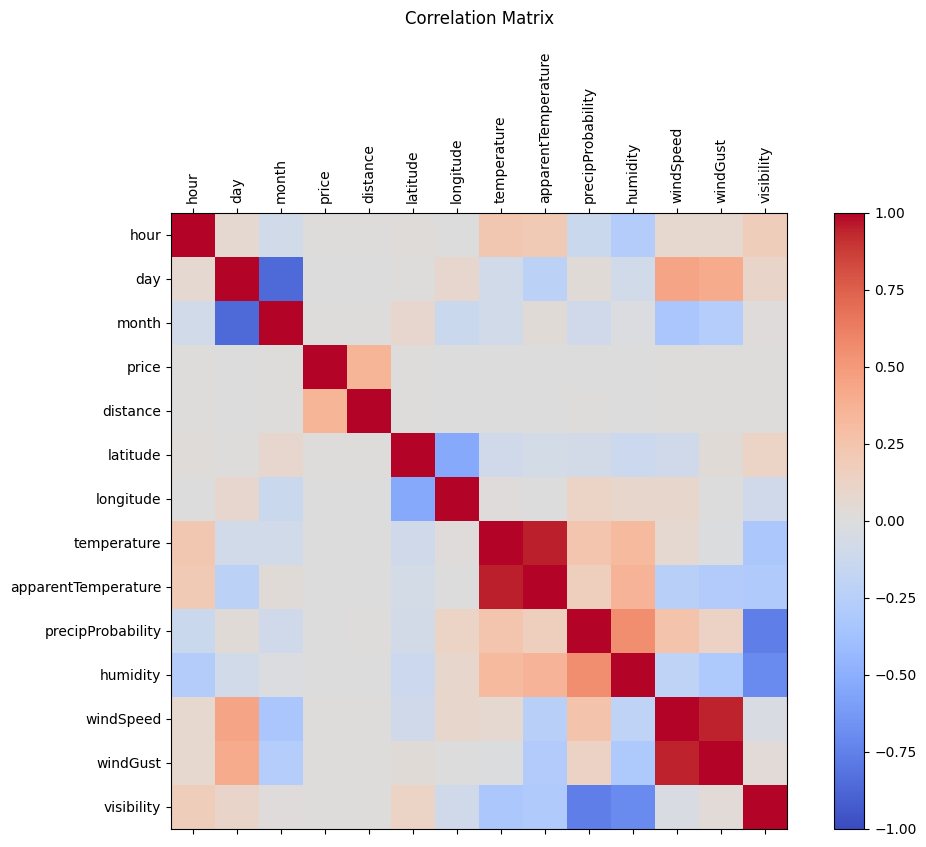

In [24]:
correlated_features = [
    "hour", "day", "month", "price", "distance",
    "latitude", "longitude", "temperature", "apparentTemperature",
    "precipProbability", "humidity", "windSpeed", "windGust", "visibility"
]

# Select only those features from the dataset
correlated_data = data[correlated_features]

# Filter numeric columns (optional safety check)
correlated_numeric_data = correlated_data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = correlated_numeric_data.corr()

# Plot the matrix
fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Add color bar
fig.colorbar(cax)

# Set axis ticks and labels
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.columns)

# Add a title
plt.title('Correlation Matrix', pad=20)

# Show the plot
plt.show()

In [25]:
# Selecionar apenas colunas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Calcular matriz de correlação
correlation_matrix = numeric_data.corr()

correlation_matrix


,timestamp,hour,day,month,price,distance,surge_multiplier,latitude,longitude,temperature,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
timestamp,1.000000,-0.028004,-0.341292,0.771182,0.000808,0.003553,0.000572,0.168130,-0.136802,-0.248748,...,-0.211700,0.999364,-0.306971,0.998194,-0.186328,0.999290,-0.378346,0.998286,-0.157748,0.999276
hour,-0.028004,1.000000,0.066090,-0.079379,0.000561,0.002280,-0.000077,0.019493,-0.006295,0.218769,...,0.019940,-0.027518,0.015513,-0.027027,0.002958,-0.027990,0.015820,-0.027704,0.002897,-0.027785
day,-0.341292,0.066090,1.000000,-0.861306,-0.000722,-0.000627,0.001389,0.006838,0.078690,-0.084116,...,0.145568,-0.341198,0.038076,-0.333990,-0.304870,-0.344532,-0.019940,-0.335043,-0.444445,-0.344411
month,0.771182,-0.079379,-0.861306,1.000000,0.000913,0.002298,-0.000628,0.085791,-0.126912,-0.081774,...,-0.213054,0.770767,-0.191803,0.765255,0.105326,0.772989,-0.191153,0.766031,0.215076,0.772896
price,0.000808,0.000561,-0.000722,0.000913,1.000000,0.345061,0.240458,0.002088,-0.001417,-0.000084,...,0.001114,0.000763,-0.000428,0.000769,-0.000550,0.000766,-0.000580,0.000814,-0.000290,0.000746
distance,0.003553,0.002280,-0.000627,0.002298,0.345061,1.000000,0.024769,0.000819,-0.000293,-0.002884,...,0.000648,0.003562,-0.003396,0.003428,-0.004191,0.003580,-0.003937,0.003526,-0.004238,0.003584
surge_multiplier,0.000572,-0.000077,0.001389,-0.000628,0.240458,0.024769,1.000000,0.001375,-0.001829,-0.001572,...,-0.000101,0.000544,-0.000724,0.000554,-0.001951,0.000522,-0.001304,0.000464,-0.002154,0.000519
latitude,0.168130,0.019493,0.006838,0.085791,0.002088,0.000819,0.001375,1.000000,-0.531259,-0.098604,...,-0.047535,0.171820,-0.114185,0.169592,-0.108953,0.175177,-0.096084,0.170921,-0.082600,0.173206
longitude,-0.136802,-0.006295,0.078690,-0.126912,-0.001417,-0.000293,-0.001829,-0.531259,1.000000,0.012183,...,0.030753,-0.136724,0.048723,-0.140403,-0.007274,-0.137041,0.010138,-0.140518,-0.022854,-0.135621
temperature,-0.248748,0.218769,-0.084116,-0.081774,-0.000084,-0.002884,-0.001572,-0.098604,0.012183,1.000000,...,0.333081,-0.254467,0.789261,-0.242698,0.780546,-0.253881,0.817521,-0.231513,0.703208,-0.255288


# 3.0 Feature Engineering


## 3.1 Incorrect data

As we saw on topic 2.2 surge multiplier is not beeing used by Uber

Because of that, it was decided not to use in the model.

In [26]:
data.drop(axis=1, columns=["surge_multiplier"], inplace=True)

We also saw that there are missing values in price, they can not be used or replaced because our target variable is price.

In [27]:
# drop the rows that does not contain the price
data = data.dropna()

# checking what was deleted
# data.info()

## 3.2 Feature Date Time

The goal is to combine the four date-related features into a single feature that captures meaningful time patterns to help the model better understand price behavior. Data wrangling can support us in this process.

In [28]:
# Convert 'datetime' to datetime type in pandas
data['datetime'] = pd.to_datetime(data['datetime'])

# Extract the day of the week as full name
data['weekday'] = data['datetime'].dt.day_name()


In [29]:
# Mean to each day of the week
avg_price_by_day = data.groupby('weekday')['price'].mean()

print(avg_price_by_day)



weekday
Friday       16.488975
Monday       16.492948
Saturday     16.566569
Sunday       16.571859
Thursday     16.574373
Tuesday      16.590444
Wednesday    16.526189
Name: price, dtype: float64


## 3.2 Encoding 

In [30]:
product_id_values = set()

# What are the possible names
for value in data['name']:
    if value not in product_id_values:
        product_id_values.add(value)

product_id_values = list(product_id_values)

print(product_id_values)

['Lyft', 'WAV', 'UberPool', 'UberX', 'Black SUV', 'Black', 'UberXL', 'Shared', 'Lux Black', 'Lux Black XL', 'Lux', 'Lyft XL']


### 3.2.1 Using data wrangling to encode the types of rides

In [31]:
# Calculate average price for each ride category 
avg_price_by_category = data.groupby('name')['price'].mean().sort_values(ascending=False)

# Show the result
print(avg_price_by_category)

#the goal is to understand which categories are more expensive


name
Lux Black XL    32.324086
Black SUV       30.286763
Lux Black       23.062468
Black           20.523786
Lux             17.771240
UberXL          15.678144
Lyft XL         15.309363
UberX            9.765074
WAV              9.765019
Lyft             9.610885
UberPool         8.752500
Shared           6.029893
Name: price, dtype: float64


Now we have all the values to each type of ride, it is possible to encode using numbers

In [32]:
# Define ride categories ordered by average price (most premium to most basic)
ride_class_mapping = {
    'Lux Black XL': 12,
    'Black SUV': 11,
    'Lux Black': 10,
    'Black': 9,
    'Lux': 8,
    'UberXL': 7,
    'Lyft XL': 6,
    'UberX': 5,
    'WAV': 4,
    'Lyft': 3,
    'UberPool': 2,
    'Shared': 1
}

# Map each ride category to a ride_class score
data['ride_class'] = data['name'].map(ride_class_mapping)


#### Convert the 'cab_type' column to a binary variable:
 Uber → 1 and Lyft → 0

 changing the name of the column

In [33]:
data['cab_type'] = data['cab_type'].map({'Uber': 1, 'Lyft': 0})

data.rename(columns={'cab_type': 'uber'}, inplace=True)


## 3.4 Unit Conversion

In [34]:
# changing the distance from Miles to Kilometers 

# it is more usual outside EUA

data['distance'] = data['distance'] * 1.60934


In [35]:
data[0:5]

,id,timestamp,hour,day,month,datetime,timezone,source,destination,uber,...,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,weekday,ride_class
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,0,...,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000,Sunday,1
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,0,...,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600,Tuesday,8
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,0,...,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000,Wednesday,3
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,0,...,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800,Friday,12
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,0,...,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800,Thursday,6


# 4.0 

In [39]:

# Relevant features selection
features = ['uber', 'distance', 'temperature', 'weekday', 'ride_class']

# Target variable
target = 'price'

# Extract features and target
df_model = data[features + [target]]

# Encode categorical features
df_encoded = pd.get_dummies(data[features + ['price']], columns=['weekday'], drop_first=True)


# Define features (X) and target (y)
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

from sklearn.model_selection import train_test_split

# Splitting into training (80%) and testing (20%) datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the shape of the datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Creating the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

(510380, 10) (127596, 10) (510380,) (127596,)
Mean Absolute Error (MAE): 1.62
Root Mean Squared Error (RMSE): 2.89


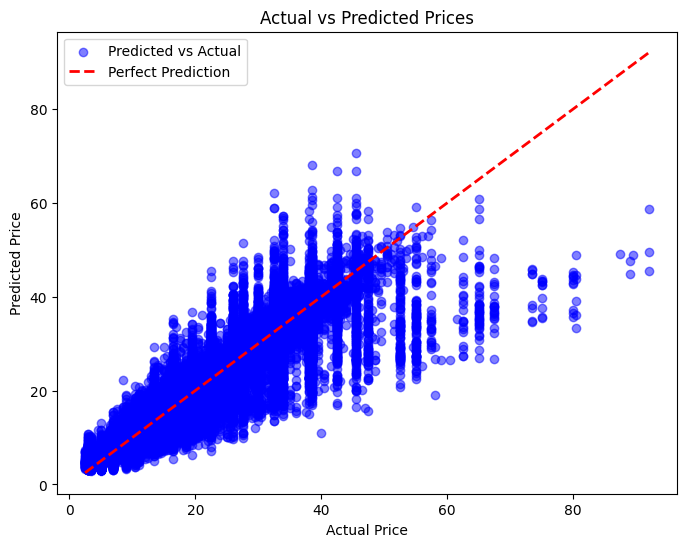

In [40]:
# Plot actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs Actual", color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction")  # Reference line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.show()
